# Browse Runs

Interactive notebook for monitoring training progress and visualizing runs.

**Usage:** Re-run this notebook to get the latest training status.

**CLI commands** (from `tdmpc2/` directory):
```bash
python -m discover status     # Quick status overview
python -m discover running    # Currently running tasks
python -m discover tasks      # All tasks with progress (225 official tasks)
python -m discover tasks --all  # Include non-official tasks (smoke-test, etc.)
python -m discover restart    # Show restart commands (add --submit to run)
python -m discover --help     # All available commands
```

## Setup

In [1]:
from pathlib import Path
import sys

# Ensure repo root is importable
ROOT = Path('..').resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# Change to ROOT for CLI commands
%cd {ROOT}

# Import the discover API
from discover import load_df, get_target_step
from discover.plots import training_overview, plot_max_steps, progress_by_domain

TARGET_STEP = get_target_step()
print(f"TARGET_STEP: {TARGET_STEP:,}")

/home/projects/dharel/nadavt/repos/newt/tdmpc2
TARGET_STEP: 5,000,000


/home/projects/dharel/nadavt/.conda/envs/newt/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Load Runs Data

In [2]:
# load_df() loads merged runs from local logs + wandb (uses cache by default)
# Set refresh=True to force re-fetch from sources
df_all = load_df(refresh=True)
print(f"Loaded {len(df_all)} runs")

Scanning local logs (/home/projects/dharel/nadavt/repos/newt/tdmpc2/logs)...
  1123 local runs found        
Fetching runs from wandb (wm-planning/mmbench)...
wandb: Currently logged in as: nadav-timor (wm-planning) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
  Listed 2492 runs in 475.7s
  Fetching run details (parallel)...


Loaded 3615 runs


  Fetched 2492 run details in 45.7s (55/s)


## Training Progress Overview

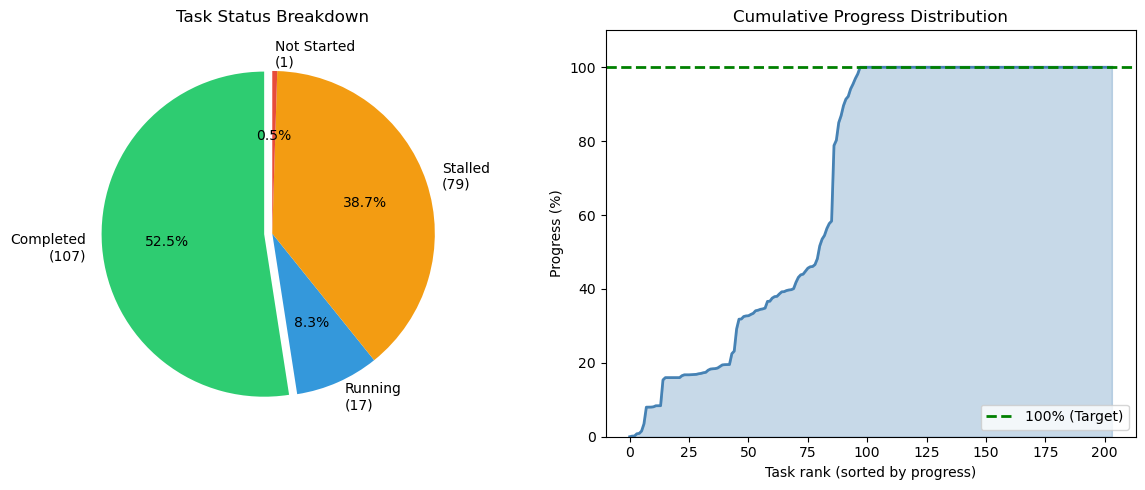

                 TRAINING PROGRESS SUMMARY                  
  Total tasks:            204
  Target step:         5,000,000
------------------------------------------------------------
  🟢 ✅ Completed:         107 (52.5%)
  🔵 🏃 Running:            17 (8.3%)  <- active in wandb
  🟠 ⏸️  Stalled:            79 (38.7%)  <- needs restart
  🔴 ❌ Not Started:         1 (0.5%)
------------------------------------------------------------
  Average progress:      68.5%
  Median progress:      100.0%
  Min steps:                0
  Max steps:           5,000,000


In [3]:
# training_overview: pie chart + summary stats
# Categories: Completed, Running (wandb-verified), Stalled (needs restart), Not Started
training_overview(df_all, target_step=TARGET_STEP)

## Currently Running / Needs Restart (CLI)


In [4]:
# CLI: list all tasks with progress, running count, and status
# Options: --format json|csv, --not-started, --stalled, --running, --completed
!python -m discover tasks

                                   ALL TASKS                                    
Task                                            Progress     Max Step   Runs   Status
--------------------------------------------------------------------------------
   cartpole-balance-long-sparse                    0.0%            0      0        🔴
   cartpole-balance-two-poles-sparse               0.0%            0      0        🔴
   ms-pick-cup                                     0.0%            0      0        🔴
   ms-pick-golf-ball                               0.0%            0      0        🔴
   ms-pick-rubiks-cube                             0.0%            0      0        🔴
   ms-pick-soccer-ball                             0.0%            0      0        🔴
   ms-push-apple                                   0.0%            0      0        🔴
   ms-push-banana                                  0.0%            0      0        🔴
   ms-push-can                                     0.0%            0    

In [5]:
# CLI: progress aggregated by domain prefix (walker-*, mw-*, etc.)
!python -m discover domains

                               PROGRESS BY DOMAIN                               
Domain                  Tasks   Complete   Avg Progress   Completion %
--------------------------------------------------------------------------------
acrobot                     1          1         100.0%         100.0%
cheetah                     5          5         100.0%         100.0%
cartpole                    4          4         100.0%         100.0%
cup                         2          2         100.0%         100.0%
finger                      3          3         100.0%         100.0%
giraffe                     1          1         100.0%         100.0%
fish                        1          1         100.0%         100.0%
walker                      5          5         100.0%         100.0%
spinner                     3          3         100.0%         100.0%
hopper                      3          3         100.0%         100.0%
jumper                      1          1         100.0%  

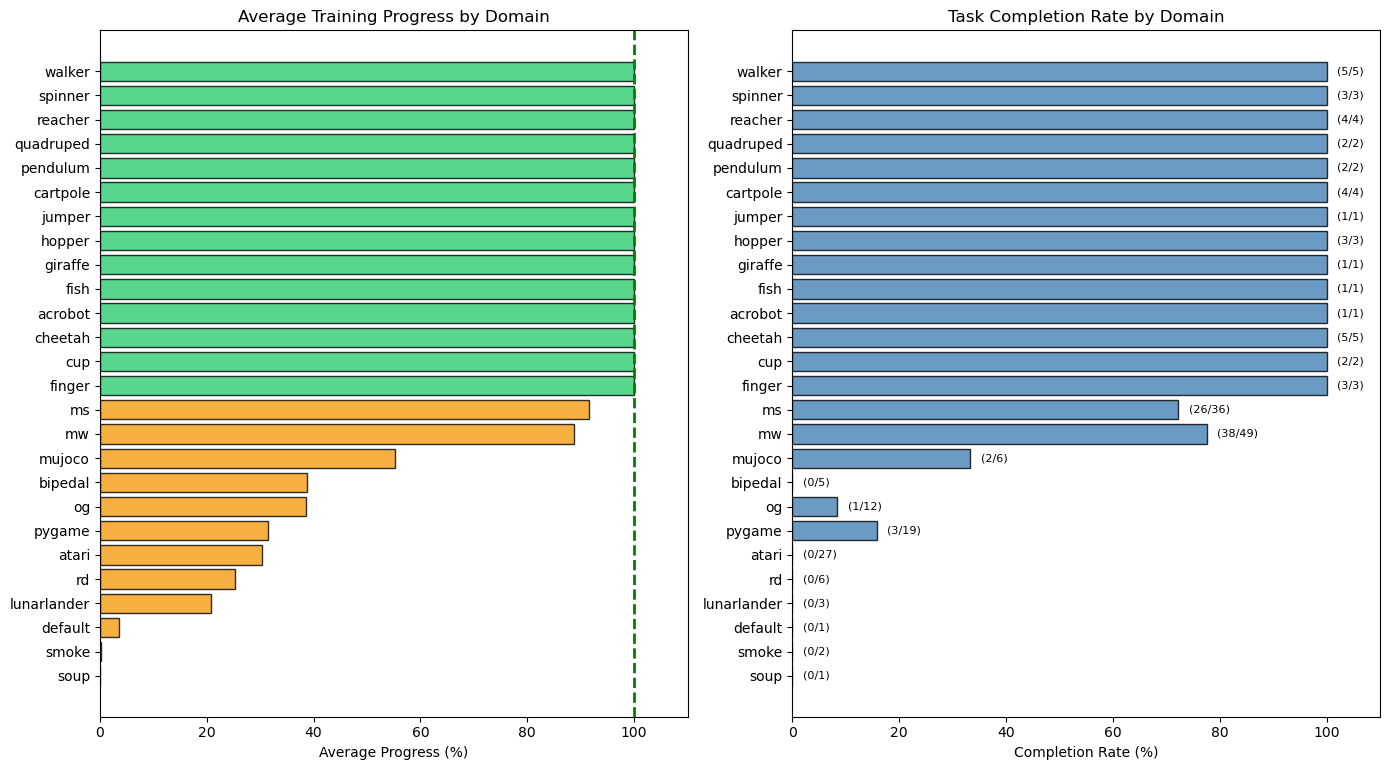


Domain Summary:
--------------------------------------------------------------------------------
Domain                  Tasks   Complete   Avg Progress   Completion %
--------------------------------------------------------------------------------
reacher                     4          4         100.0%         100.0%
quadruped                   2          2         100.0%         100.0%
hopper                      3          3         100.0%         100.0%
jumper                      1          1         100.0%         100.0%
giraffe                     1          1         100.0%         100.0%
fish                        1          1         100.0%         100.0%
cheetah                     5          5         100.0%         100.0%
acrobot                     1          1         100.0%         100.0%
finger                      3          3         100.0%         100.0%
cup                         2          2         100.0%         100.0%
spinner                     3          3

In [6]:
# progress_by_domain: visualization of domain-level progress
progress_by_domain(df_all, target_step=TARGET_STEP)

## 4. Currently Running


In [7]:
# CLI: shows wandb-verified running runs (not stale local status)
# Note: wandb "running" may include LSF-suspended (SSUSP) jobs
!python -m discover running

                         RUNNING RUNS SUMMARY                         
  Running runs (wandb):          22  ✓ confirmed by wandb
  Stale local 'running':        951  ⚠️  (local-only, likely crashed)
  Tasks with running runs:       17
  Tasks needing restart:         74  ⚠️  (incomplete, no active run)
  Tasks with stale runs:          4  🔄 (>1 wandb run, from resume)

🏃 CURRENTLY RUNNING TASKS (17 tasks, 22 runs per wandb):
   Note: wandb 'running' may include LSF-suspended jobs (SSUSP)
----------------------------------------------------------------------
Task                                       Runs     Progress     Max Step
----------------------------------------------------------------------
   mujoco-halfcheetah                         1       41.8%    2,090,000
   mujoco-ant                                 1       44.0%    2,200,000
   ms-pick-baseball                           1       44.8%    2,240,400
   ms-pick-screwdriver                        1       51.6%    2,582,000

## 5. Needs Restart

In [8]:
# CLI: shows bsub commands for stalled tasks (dry-run by default)
# Add --submit to actually execute the bsub commands
!python -m discover restart

                         RUNNING RUNS SUMMARY                         
  Running runs (wandb):          22  ✓ confirmed by wandb
  Stale local 'running':        951  ⚠️  (local-only, likely crashed)
  Tasks with running runs:       17
  Tasks needing restart:         74  ⚠️  (incomplete, no active run)
  Tasks with stale runs:          4  🔄 (>1 wandb run, from resume)

⚠️  TASKS NEEDING RESTART (74 tasks, no active runs in wandb):
----------------------------------------------------------------------
Task                                         Progress        Max Step
----------------------------------------------------------------------
   atari-yars-revenge                          97.0%       4,848,000
   atari-upndown                               95.4%       4,772,000
   pygame-landing                              78.8%       3,941,200
   mw-push-back                                48.2%       2,409,600
   og-ant                                      46.6%       2,330,000
   mw-pl

In [9]:
# # submitting all non-completed tasks (stalled or not started)
# !python -m discover restart --submit

## 6. Eval Status

In [10]:
# CLI: list tasks ready for eval (≥50% trained) and their video status
# Use 'python -m discover eval submit --submit' to generate and submit eval jobs
!python -m discover eval list

                   TASKS READY FOR EVALUATION (≥50% trained)                    

Total tasks at ≥50%: 124
  ✅ With videos:    124
  ❌ Without videos: 0

────────────────────────────────────────────────────────────────────────────────
Tasks WITH videos:
────────────────────────────────────────────────────────────────────────────────
  ✅ acrobot-swingup                                5,000,000 (100.0%)
  ✅ cartpole-swingup                               5,000,000 (100.0%)
  ✅ cartpole-balance-sparse                        5,000,000 (100.0%)
  ✅ cartpole-balance                               5,000,000 (100.0%)
  ✅ cheetah-jump                                   5,000,000 (100.0%)
  ✅ cheetah-run                                    5,000,000 (100.0%)
  ✅ cheetah-run-back                               5,000,000 (100.0%)
  ✅ cartpole-swingup-sparse                        5,000,000 (100.0%)
  ✅ cheetah-run-backward                           5,000,000 (100.0%)
  ✅ cup-spin                       

## 7. Collect Videos

In [11]:
# CLI: collect videos from trained tasks into videos_for_presentation/
# Options: --min-progress 0.5, --copy (instead of symlinks), --output <dir>
# Then: rsync -avz server:tdmpc2/discover/videos_for_presentation/ ./videos/
!python -m discover videos collect

                       VIDEOS COLLECTED FOR PRESENTATION                        

📁 Output directory: /home/projects/dharel/nadavt/repos/newt/tdmpc2/discover/videos_for_presentation
   Total videos: 124
   Method: symlinks

────────────────────────────────────────────────────────────────────────────────
Task                                                  Step   Progress
────────────────────────────────────────────────────────────────────────────────
  acrobot-swingup                                5,000,000     100.0%
  atari-upndown                                  4,772,000      95.4%
  atari-yars-revenge                             4,848,000      97.0%
  bipedal-walker-rugged                          2,884,500      57.7%
  cartpole-balance                               5,000,000     100.0%
  cartpole-balance-sparse                        5,000,000     100.0%
  cartpole-swingup                               5,000,000     100.0%
  cartpole-swingup-sparse                        5,000